In [2]:
from QS_Modules import env, fb_login
from QS_Modules.models import Query, Track, Monitor, Topic, TrackError
import matplotlib.pyplot as plt
import pymysql
import pymysql.cursors
from datetime import datetime, timedelta

DRIVER_PATH = env.DRIVER_PATH
MYSQL_PWD = env.MYSQL_PWD
MYSQL_ACCOUNT = env.MYSQL_ACCOUNT
MYSQL_ROUTE = env.MYSQL_ROUTE
MYSQL_PORT = env.MYSQL_PORT
MYSQL_DB = env.MYSQL_DB

QUERY = Query(
    host=MYSQL_ROUTE,
    user=MYSQL_ACCOUNT,
    pwd=MYSQL_PWD,
    port=MYSQL_PORT,
    db_name=MYSQL_DB
)

CONNECTION = pymysql.connect(host=MYSQL_ROUTE,
                             user=MYSQL_ACCOUNT,
                             password=MYSQL_PWD,
                             database=MYSQL_DB,
                             cursorclass=pymysql.cursors.DictCursor)

In [3]:
class Plot():
    def __init__(self, QUERY, CONNECTION):
        self.QUERY = QUERY
        self.CONNECTION = CONNECTION

    def plot_view_count_plt(self, url):
        session = self.QUERY.session
        raw = session.query(Track).filter(Track.url == url)
        topic_info = session.query(Topic).filter(Topic.url == url).first()
        relocated = session.query(TrackError).filter(TrackError == url).first()
        if relocated is None:
            relocated = '否'
        else:
            relocated = '是'
        topic_title = topic_info.title
        post_time = topic_info.post_time+timedelta(hours=8)
        start_track_at = topic_info.triggered_at+timedelta(hours=8)
        stop_track_at = topic_info.stop_track_at+timedelta(hours=8)
        results = [QUERY.to_dict(i) for i in raw.all()]
        print(f'文章標題：{topic_title}\n發文時間：{post_time}\n追蹤次數：{len(results)}\n首次追蹤於：{start_track_at}\n停止追蹤於：{stop_track_at}\n是否被移至板務區：{relocated}')
        x = [i['triggered_at']+timedelta(hours=8) for i in results]
        y = [i['view_count'] for i in results]
        xtick_lables = [i.strftime('%m-%d %H:%M') for i in x]
        plt.rcParams["figure.figsize"] = (24, 6)
        fig = plt.figure()
        ax = plt.gca()
        ax.plot(x, y, linestyle='--', marker='o')
        plt.xticks(x, xtick_lables, rotation=0, fontsize=12)
        plt.yticks(fontsize=14)
        plt.title(f'View count of: {url}', fontsize=28)
        plt.xlabel('triggered_at', fontsize=24)
        plt.ylabel('view_count', fontsize=24)
        plt.show()
        
    def plot_monitor_plt(self, start_date_str='2021-07-16', stop_date_str='2021-07-23'):
        session = self.QUERY.session
        raw = session.query(Monitor).filter(Monitor.triggered_at >= start_date_str).filter(Monitor.triggered_at <= stop_date_str)
        results = [QUERY.to_dict(i) for i in raw.all()]
        new_topics_count = [i['new_topics_count'] for i in results]
        target_topics_count = [i['target_topics_count'] for i in results]
        execution_count = [i['execution_count'] for i in results]
        triggered_at = [i['triggered_at']+timedelta(hours=8) for i in results]
        plt.rcParams["figure.figsize"] = (24, 6)
        fig = plt.figure()
        ax = plt.gca()
        ax.plot(triggered_at, new_topics_count, label='New Topics')
        ax.plot(triggered_at, target_topics_count, label='Target Topics')
        ax.plot(triggered_at, execution_count, label='Tracked Topics')
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=14)
        plt.title('Monitor', fontsize=28)
        plt.xlabel('triggered_at', fontsize=24)
        plt.ylabel('topic_count', fontsize=24)
        plt.legend(fontsize=20)
        plt.show()
    
    def plot_first_show(self, start_date_str='2021-07-15 13:00:25', stop_date_str='2021-07-16'):
        connection = self.CONNECTION
        with connection.cursor() as cursor:
            sql = """
                    select count(topic.topic_id), track.view_count
                    from topic
                    join track on topic.url = track.url
                    where topic.triggered_at = track.triggered_at
                    and topic.triggered_at <= %s
                    and topic.post_time >= %s
                    group by track.view_count
                    order by track.view_count;
                """
            cursor.execute(sql, (stop_date_str, start_date_str))
            results = cursor.fetchall()
        topic_count = [i['count(topic.topic_id)'] for i in results]
        view_counts = [i['view_count'] for i in results]
        plt.rcParams["figure.figsize"] = (24, 6)
        fig = plt.figure()
        ax = plt.gca()
        ax.bar(range(len(view_counts)), topic_count, width=0.8)
        plt.xticks(range(len(view_counts)), view_counts, fontsize=12)
        plt.yticks(fontsize=14)
        plt.title(f'Topic Count with Different view_count: from 2021-07-15 to {stop_date_str}', fontsize=28)
        plt.xlabel('view_count', fontsize=24)
        plt.ylabel('topic_count', fontsize=24)
        plt.show()


plot = Plot(QUERY, CONNECTION)

文章標題：[找整修/設計廠商]新北樹林30年透天厝全棟
發文時間：2021-07-20 09:07:00
追蹤次數：14
首次追蹤於：2021-07-20 09:30:25
停止追蹤於：2021-07-20 16:30:25
是否被移至板務區：否


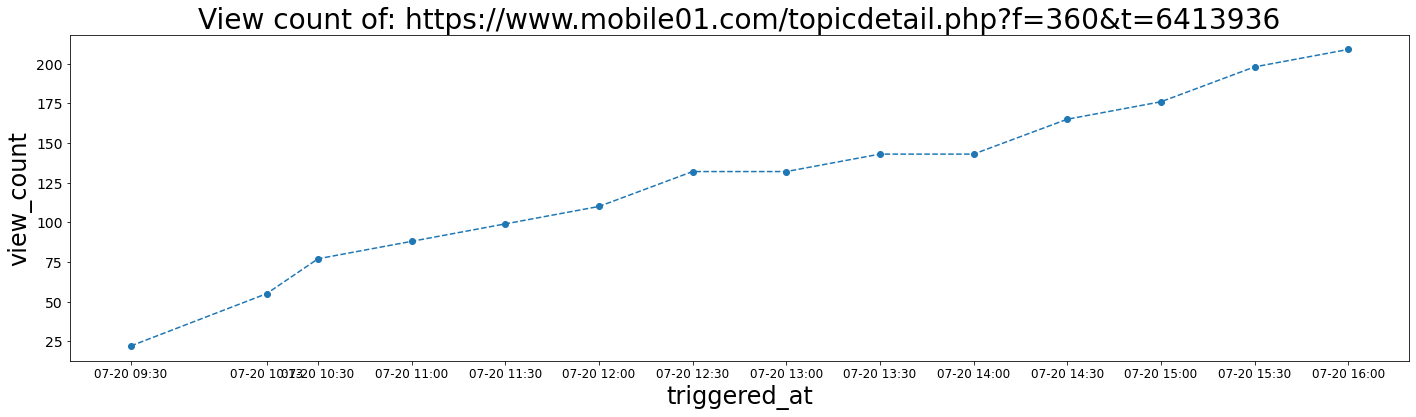

In [8]:
url = 'https://www.mobile01.com/topicdetail.php?f=360&t=6413936'
plot.plot_view_count_plt(url)

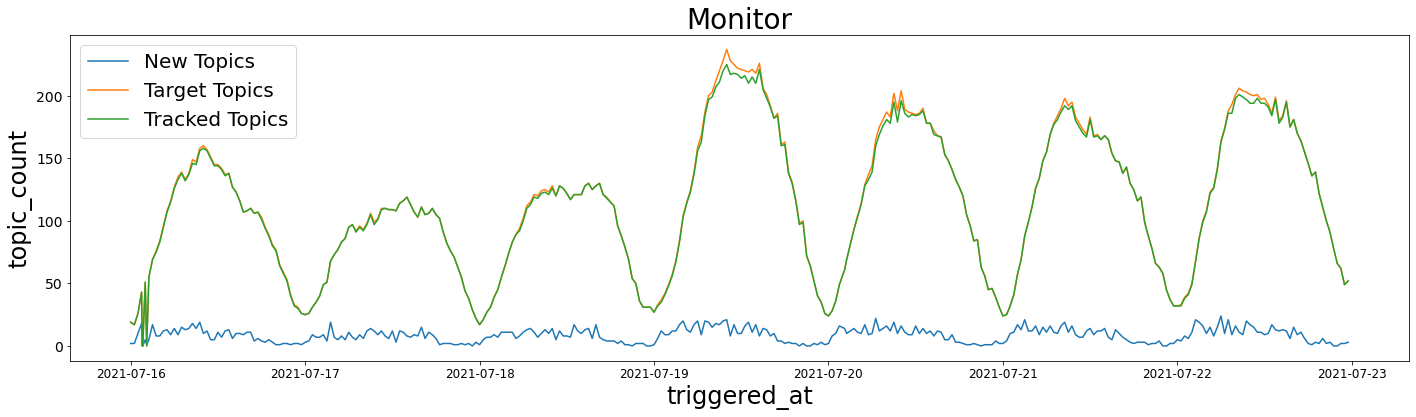

In [31]:
plot.plot_monitor_plt(start_date_str='2021-07-16')

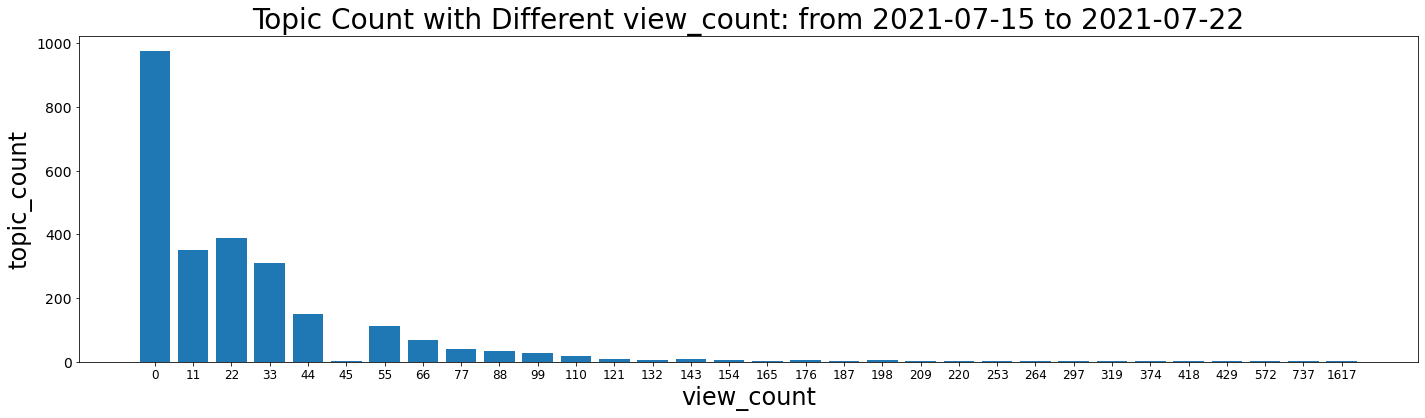

In [32]:
plot.plot_first_show(stop_date_str='2021-07-22')

In [10]:
FB_TEST_EMAIL = env.FB_TEST_EMAIL
FB_TEST_PWD = env.FB_TEST_PWD
thread_id = 100070719168616
msg = '測試0723-02'
headers = {
    "Content-Length": "467",
    "User-Agent":
    "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/60.0.3112.50 Safari/537.36",
    "Content-Type": "application/x-www-form-urlencoded",
    "Accept": "*/*",
    "Origin": "https://www.messenger.com",
    "Referer": "https://www.messenger.com/",
}

http_fb = fb_login.HTTPFB(headers, FB_TEST_EMAIL, FB_TEST_PWD, msg, thread_id)
http_fb.main()

<Response [200]>


In [136]:
FB_REAL_EMAIL = env.FB_REAL_EMAIL
FB_REAL_PWD = env.FB_REAL_PWD
QSEARCH_THREAD = 430401096982804
thread_id = QSEARCH_THREAD
msg = '測試0722'

http_fb = fb_login.HTTPFB(headers, FB_REAL_EMAIL, FB_REAL_PWD, msg, thread_id)
http_fb.main()

<Response [200]>
